# Experiment 6：有噪声环境下的代理模型数据驱动优化

目的：最小化 / 最大化一个函数，但这个函数没有解析公式且带噪声，只能通过实验/仿真得到结果

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
##这是高斯过程回归的核函数
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
##kernels是高斯过程回归的核心，核函数定义了数据点之间的相似度。
##RBF（径向基函数）核是一种常用的核函数，它能够捕捉数据中的平滑变化。
##WhiteKernel是一个噪声核，用于建模观测数据中的噪声。

In [23]:
def true_function(x):
    return np.sin(3*x)

def noisy_function(x):
    noise = np.random.normal(0, 0.1)
    return np.sin(3*x) + noise

### 采样初始点，计算带噪声的函数值

In [24]:
np.random.seed(0)
X=np.random.uniform(0,2,size=(5,1))##uniform函数生成一个随机数，范围在0到2之间,size表示生成5行1列的二维数组
y=np.array([noisy_function(x[0]) for x in X])##生成5个随机数，并将它们传递给noisy_function函数，得到对应的y值
X,y

(array([[1.09762701],
        [1.43037873],
        [1.20552675],
        [1.08976637],
        [0.8473096 ]]),
 array([-0.23498432, -0.71558494, -0.33071557, -0.17794726,  0.81888509]))

### 训练代理模型

In [25]:
kernel=RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
##定义核函数，RBF核用于捕捉数据中的平滑变化，WhiteKernel用于建模观测数据中的噪声

gp=GaussianProcessRegressor(kernel=kernel)##创建高斯过程回归模型，并将定义的核函数传递给它
gp.fit(X,y)##使用训练数据拟合高斯过程回归模型

,kernel,RBF(length_sc...ise_level=0.1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,RBF(length_scale=1)
,kernel__k2,WhiteKernel(noise_level=0.1)
,kernel__k1__length_scale,1.0


### 在代理模型上优化采样准则

Exploration（探索）：不确定但可能好，对应std      
Exploitation（利用）：看起来已经不错，对应mean     
beta来权衡这二者

In [26]:
def acquisition_function(x, gp,beta=2.0):
    ##获取高斯过程回归模型的预测均值和标准差,beta是一个参数，用于控制探索和利用之间的权衡
    mean, std = gp.predict(x.reshape(-1, 1), return_std=True)
    ##mean是高斯过程回归模型对输入x的预测均值，std是预测的不确定性（标准差）
    ##acquisition_function的值是预测均值加上一个不确定性项，beta控制了不确定性在采集函数中的权重
    
    return mean + beta * std
    ##return mean + beta * std表示在选择下一个采样点时，考虑预测的均值与不确定性，以便在探索和利用之间取得平衡

### 决定下一个真实评估点

In [27]:
x_candidates = np.linspace(0, 2, 200)
scores = acquisition_function(x_candidates, gp)

x_next = x_candidates[np.argmax(scores)]
##x_candidates[np.argmax(scores)]返回对应索引的x_candidates中的值，即下一个采样点的位置

In [28]:
y_next=noisy_function(x_next)

X=np.vstack((X,[[x_next]]))
##vstack函数将两个数组按垂直方向（行）进行堆叠，形成一个新的数组。这里将新的采样点x_next添加到原来的训练数据X中。
y=np.append(y,y_next)
##append函数将新的观测值y_next添加到原来的观测数据y中。

gp.fit(X,y)

,kernel,RBF(length_sc...ise_level=0.1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,RBF(length_scale=1)
,kernel__k2,WhiteKernel(noise_level=0.1)
,kernel__k1__length_scale,1.0


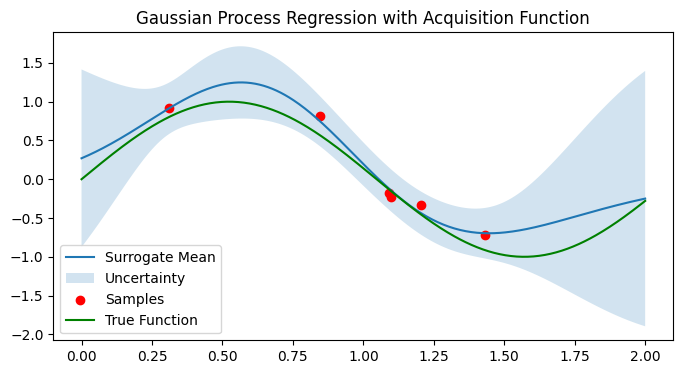

In [29]:
x_plot = np.linspace(0, 2, 400)
mean, std = gp.predict(x_plot.reshape(-1, 1), return_std=True)

plt.figure(figsize=(8, 4))
plt.plot(x_plot, mean, label="Surrogate Mean")
plt.fill_between(
    x_plot,
    mean - 2 * std,
    mean + 2 * std,
    alpha=0.2,
    label="Uncertainty"
)
plt.scatter(X, y, color="red", label="Samples")
plt.plot(x_plot,true_function(x_plot),color="green",label="True Function")
plt.title("Gaussian Process Regression with Acquisition Function")
plt.legend()
plt.show()


## 结论

代理模型优化能高效地近似带噪音的目标函数并减少测试成本